# Reverse perturbation tutorial
## Tutorial 1: Lennard-Jones fluid

Make sure that hoomd-blue and azplugins are installed correctly. For more details see Tutorial 0.  

In this tutorial, we will use the azplugins implementation of the [reverse perturbation method](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.59.4894) by M&uuml;ller-Plathe to generate shear flow in a simple Lennard-Jones fluid. I recommend reading this paper before you continue with the tutorial to familarize yourself with the method. The main benefit of this method over other non-equilibrium techniques to generate shear is that it is relatively straightforward to compute the viscosity of the fluid. The basic idea is to exchange momentum between two areas of the simulation box in an unphysical way by swapping momentum of particles and to observe the physical response of the system, the velocity gradient because of the momentum flux. Commonly, simulations are done the other way around: a velocity gradient is generated and the stress/momentum is measured. Often, it is difficult to measure stress in the simulation, but it generally very easy to measure a velocity gradient. 

The simulation box in the azplugin is set up as shown below. Hoomd convention is that the box dimensions go from $-L/2$ to $L/2$ in each dimension, such that the origin is in the center of the simulation box. For the reverse perturbation plugin, the $x$ direction is the flow direction and the $z$ is the gradient direction. The locations of the two layers where the momentum exchanges are performed are at $\pm L_z/4$. Each layer has a thickness of `width=`$w$. I recommend using cubic boxes or boxes elongated in the gradient direction only. For details please see this [publication](https://arxiv.org/pdf/1811.04097.pdf) and references therein, as well as the follow up [publication](https://arxiv.org/pdf/1907.07086.pdf).

![system](system_sketch.png)

As you can see, a triangular shaped flow is established from swapping momentum between particles in the two exchange regions. Because of periodic boundary conditions, the box contains two linear shear regions between the two exchange regions. 

To decide which particle pairs momentum to swap, the original publication uses the particles in the exchange region which have the largest momentum in the opposing direction of the flow. For more control over the flow, the plugin follows this [publication](https://doi.org/10.1063/1.3276454) and allows you to specify a target momentum with the variable ``target_momentum`` instead of picking the largest opposing pair. This way, the algorithm uses the pair with momentum closest to $\pm$``target_momentum``, resulting in a more consistent, predictable momentum swap each time. 

### System setup

First, we need to set up a simple equlibrated Lennard-Jones fluid simulation. If you are not familiar with this, check out the [hoomd-blue tutorial](https://nbviewer.jupyter.org/github/glotzerlab/hoomd-examples/blob/master/Tutorial%20-%20MD%20-%20Lennard%20Jones.ipynb). In principle, the reverse perturbation algorithm can be applied to many different systems. We have found it to work best with fairly homogeneous fluid-like systems, strongly ordered or gel-like networks might not work as nicely. I strongly suggest to do extensive testing for your system of choice if you wish to apply the reverse perturbation method to a new setting. Start with a pure solvent, confirming known fluid properties and check the flow profile extensively.

The reverse perturbation method conserves both momentum and kinetic energy and should not need a thermostat. In fact, it does not work well if you apply a strongly coupled global thermostat! If your system needs thermostatting, you may want to either use a local cell based thermostat or thermostat only the non-swapped dimensions. 

The code below imports all needed modules, defines some variables for the simulations and initialized a hoomd simulation context. You do not need to copy and paste all code lines, the complete .py script is in the tutorials folder. If you want to execute this tutorial step by step interactively, download the jupyter .ipynb notebook and run it on a locally. 

```Python
import numpy as np
import sys
import hoomd
import azplugins
from hoomd import md
from hoomd import data

L = 10
kT = 0.722
rho = 0.849
sigma = 1.0

hoomd.context.initialize()
hoomd.context.SimulationContext()
```


We want to set up a standard Lennard-Jones simulation at a reduced temperature of $k_\text{B}T=0.722$ and number density $\rho =0.848$ in a cubic box with $L = 10$. These values are close to the triple point of the LJ fluid and are the same as used in the original publication. 

We need to fill the box with non-overlapping particles of sizes $\sigma=1.0$. For this tutorial, I chose to do this in the most simplest way possible by setting them up on a square lattice, which I generated with ``np.meshgrid``. Now, if the density is not to high, I can just pick ``N`` random points on that lattice and use them as particle coordinates. If you want to use this for your own system, you might want have a more sophisticated initialization routine than this. Ideally, you would write a class or function for initialzation and call it in between ``hoomd.init.read_snapshot(..)`` and ``system.restore_snapshot(...)``, replacing the code there. 

```Python
# make an empty snapshot with 0 particles
snapshot = hoomd.data.make_snapshot(N=0,box=data.boxdim(L=L),particle_types=['A'])
# initialize the simulation system with that snapshot
system = hoomd.init.read_snapshot(snapshot)

# calculate number of particles needed for the specified density rho in the given box volume
N = int(rho*system.box.get_volume())
# resize empty snapshot to correct N - all particles have position (0,0,0) and velocity (0,0,0)
snapshot.particles.resize(N)

# generate positions on a square lattice 
l = np.arange(-L/2.,+L/2.,sigma)
positions_square_lattice = np.asarray(np.meshgrid(l, l, l)).reshape(3,-1).transpose()
np.random.shuffle(positions_square_lattice)

# assign the positions to the particles
snapshot.particles.position[:] = positions_square_lattice[:N]
# generate velocities according to the Boltzmann distribution at the given temperature kT
snapshot.particles.velocity[:] = np.random.normal(0, np.sqrt(kT), (N,3))
snapshot.particles.velocity[:] -= np.average(snapshot.particles.velocity,axis=0)

# now read the modified snapshot back into the system
system.restore_snapshot(snapshot)
```

Now, we just need to set the correct interactions for this system. In this case, we are using the standart Lennard-Jones pair potential with a cutoff of `r_cut=3.0`, $\epsilon=$ `epsilon=1.0`, and $\sigma=$`sigma=1.0`.  For convinience, I am also defining a particle group ``all`` containing all particles in the simulation. 

```Python
nl = hoomd.md.nlist.cell()
lj = hoomd.md.pair.lj(r_cut=3.0, nlist=nl)
lj.pair_coeff.set('A', 'A', epsilon=1.0, sigma=sigma)

all = hoomd.group.all()
```

### Eqilibration 

For the tutorial I just quickly "equilibrated" the system for `1e4` timesteps with the Langevin thermostat at a timestep of ``dt=0.005``. For a real simulation you will probably want to equilibrate your system properly before starting the shear flow. Choose an appropriate ensemble and thermostat and run an equilibration run first, check that it is properly equilibrated.

```Python
langevin = hoomd.md.integrate.langevin(group=all, kT=kT, seed=372)
hoomd.run(1e4) 
langevin.disable()
```

### Measuring quantities during the non-equilibrium simulation 

For measuring the flow, we will need to at least measure the $x$ velocity component in $z$ direction, $v_x(z)$. For this purpose, this class records a histogram ``H_vx`` and writes it to the disk periodically. In a real simulation, you should extend and modify this class to record all quantities of interest, including density, temperature and other velocity components in all spatial directions. We have observed all kinds of gradients, including wanted and unwanted ones when using this method, so I strongly encurage you to thorougly test this for your system/solvent of choice. 

```Python
class measure_fluid_properties:
    def __init__(self, system, binsize, L):
        self.system   = system
        self.binsize  = binsize
        self.num_bins = np.round(L/self.binsize).astype(int)
        self.H_vx     = np.zeros(self.num_bins)
        self.H_dens   = np.zeros(self.num_bins)
        self.counter  = 0
        self.range    = [-L/2.,L/2.]

    def __call__(self, timestep):
        hoomd.util.quiet_status()
        snap = self.system.take_snapshot()
        hoomd.util.unquiet_status()
        pos = snap.particles.position
        vel = snap.particles.velocity
        # pick z coordinates
        pos_z = pos[:,2]
        H_dens, edges = np.histogram(pos_z,bins = self.num_bins,range=self.range)
        H_vx, edges   = np.histogram(pos_z,weights=vel[:,0], bins = self.num_bins,range=self.range)

        self.H_dens  += H_dens
        self.H_vx    += H_vx

        if self.counter==100:
            to_save_Hvx = np.divide(self.H_vx, self.H_dens, out=np.zeros_like(self.H_vx), where=self.H_dens!=0)
            centers  =  (edges[:-1] + edges[1:])/2
            np.savetxt('tutorial_reverse_perturbation_1_LJ_vx.hist',
                       np.c_[centers,to_save_Hvx],
                       header="z, v_x")
            self.counter  = 0
        else:
            self.counter += 1
```

The next part is setting up all properties we want to record during the shear flow simulation, so we need to create and register the ``measure_fluid_properties`` class and also use hoomds ``hoomd.analyze.log`` to record the momentum exchanged during the simulation. The reverse perturbation azplugin registers a variable called ``rp_momentum`` to hoomd. It contains the value of the exchanged momentum for each execution of the timestep before. So, value reported on timestep 0 will always be zero, the value at timestep 1 will be the momentum exchanged on timestep 0, and so on. This is because of the order how things are executed within hoomd. The variable only records the value of the current execution. Meaning, if you want to know the exact amount of momentum exchanged during the simulation, you have to call 
 ``hoomd.analyze.log`` with the same period as the swapping period in ``azplugins.flow.reverse_perturbation``. Ideally, the simulation reaches a steady state and the average over a long run can be used to calculate the momentum exchange. If the simulation does not reach a steady state, calculating the viscosity is not possible in a reliable way. 

```Python
# create and register an instance of the measure_fluid_properties class  
o = measure_fluid_properties(system, binsize=1, L=L)
analyze =  hoomd.analyze.callback(o, period=1e2)

# log the temperature and exchanged momentum during the simulation 
log = hoomd.analyze.log(filename="tutorial_reverse_perturbation_1_LJ.log",
                        quantities=['rp_momentum'],
                        period=1e2,overwrite=True)

# write out a trajectory during the simulation
hoomd.dump.gsd(filename="tutorial_reverse_perturbation_1_LJ_trajectory.gsd",
               overwrite=True, period=1e2, group=all)
```

### Run the non-equilibrium simulation 

The last task is to disable the previous thermostat set up the NVE integrator. Then we can setup and enable the reverse perturbation plugin ``azplugins.flow.reverse_perturbation`` and  let the simulation run for another `2e5` timesteps.

Let the simulation run and continue reading about the ``azplugins.flow.reverse_perturbation`` parameters in the next section.

```Python
# define timestep and integrator
hoomd.md.integrate.mode_standard(dt=0.005)

nve = hoomd.md.integrate.nve(group=all)

# enable the reverse perturbation and run the simulation
f = azplugins.flow.reverse_perturbation(group=all,width=1.0,Nswap=1,period=10,target_momentum=0.5)
hoomd.run(2e5)
```

### azplugins.flow.reverse_perturbation parameters  

The plugin has a `group`, enabling you to choose which particles you would like to apply this plugin to. For example if you have solutes in solvent, you can only swap momentum of the solvent particles and leave the solutes untouched. Simply create a "solvents" group and assign the plugin to only operate on it and not all particles. 

The `width` parameter sets the width of the exchange regions. What you should choose here depends on the density and system size. Because the swapping only happens between pairs in the exchange regions, they need to be big enough to contain some particles to pick from. So, the actual thing you care about is the average number of particles in the regions. The velocity profile will be deviating from the linear behavior in the excange regions and will not result in two perfect triangles, in case of the LJ fluid it results in rounded-off tips. 
So, as a result aim for as small as possible and as big as needed. The easiest way to test it is to do a quick check of the average number of particles in the exchange regions and run various small/short simulations, recording the exchanged momentum for every swap. See if it is constant and doesn't have zero recordings in between, because zero exchanged momentum usually means that there was no pair at all to exchange momentum between, so `width` was too small. The width also limits the maximum achivable shear to a certain degree, again, if no pairs are left to swap, no momentum can be exchanged. 

The following parameters determine the value of the momentum exchanged and therefore the shear flow which is generated: 

- The parameter `Nswap` sets how many pairs are supposed to be swapped per execution. It gives the maximum, not the minimum. If the algorithm doesn't find suitable pairs, nothing will be swapped.

- The next parameter, `period` just gives the period of execution of the plugin.  It has been noted in the [literature](https://doi.org/10.1063/1.3276454) , that it is better to try to achive a more constant momentum exchange for a more steady state. What this means is, that it might be beneficial to try, for example `Nswap=2, period=1` instead of `Nswap=10, period=5`. While both combinations result in the same number of pairs swapped on average, the first one is more continous.

- The last parameter `target_momentum` tunes what the momentum swap per particle should be. This parameter, in conjunction with the other ones, can be used to set the overall momentum exchanged over time. If you choose a very large value, the algorihm is unlikely to find pairs with that momentum and will just swap the two biggest ones. For estimating realistic values I recommend to look at the Boltzmann distribution of the velocities and see what momentum values are present in the system at that temperature. If you record `rp_momentum` you should get values close to $2\cdot$`target_momentum`, because the particle in the lower exchange region had a momentum close to `+target_momentum` and the particle in the upper echchange region `-target_momentum`.

There is no easy way or standard recipie for picking the parameters. You should do some simple estimates about how much momentum you roughly want to be exchanged and vary the parameters extensively to test. 

### Analyzing the results

First, have a look at the generated trajectory. Use either [vmd](https://www.ks.uiuc.edu/Research/vmd/) with the [gsd plugin](https://github.com/mphoward/gsd-vmd), [ovito](https://www.ovito.org/), or your favorite configuration viewer. You should see a homogeneous fluid. The parameters in this tutorial generate a shear rate which is probably hard to see with the naked eye, but if you increase the shear rate, then you'll be able to see the flow. Check for inhomogeneites, bubbles or other things like that. 


Even if we can't see it with the naked eye, we can check the $v_x(z)$ histogram we recorded to see what the velocity gradient in the system actually is: 

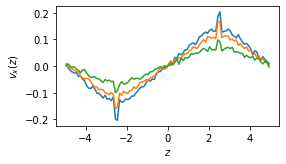

In [109]:
import numpy as np
import matplotlib.pyplot as plt

# reading the recorded velocity profile
velocity_profile = np.genfromtxt('tutorial_reverse_perturbation_1_LJ_vx.hist', skip_header=True)
# plotting the velocity profile
plt.figure(figsize=(4,2.2))
plt.plot(velocity_profile[:,0], velocity_profile[:,1])
plt.xlabel('$z$')
plt.ylabel('$v_x(z)$')
plt.show()

You should see a triangular shaped flow profile, with a maximum of $\approx 0.07$ in the upper exchange region at $L_z/4=10/4=2.5$ and a minimum of $\approx -0.07$ in the lower exchange region at $-2.5$. Because the simulation wasn't very long, the histogram isn't very smooth, which can be improved with runtime. Also note that we also recorded the startup of the flow from the quiescent equilibrated liquid. Because the simulation was short, this effect is probably significant. To avoid this start recording after the shear is established. Simply run a short shear simulation after equilibration, before recording.  The slope of the linear parts is the shear rate. 

This method of generating shear has a upper limit as well as a lower limit for the shear rate. You will see, if you increase the shear rate by swapping more and more pairs, swapping more frequently or increasing the target momentum, that the velocity profiles eventually will not be triangular anymore. This indicates that you've reached the upper level of the linear shear response regime of your fluid. For a LJ fluid, the shear profiles become sine/S-shaped. In that case, the lope is not constant, so the shear rate is also not constant, preventing the calculation of the viscosity. If your shear rate is too low, the slope will be very difficult to measure and essentially resemble noise, making your viscosity measurment very inaccurate. 

We can also check what momentum we exchange during the simulation:

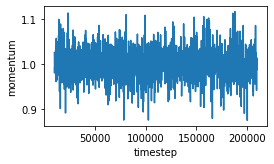

In [84]:
# reading momentum exchange
data = np.genfromtxt('tutorial_reverse_perturbation_1_LJ.log', skip_header=True)

# plotting 
plt.figure(figsize=(4,2.2))
# skipping first entry, because that one will be zero in any case
plt.plot(data[1:,0], data[1:,1])
plt.xlabel('timestep')
plt.ylabel('momentum')
plt.show()

Because we used `Nswap=1` and `target_momentum=0.5`, each time the plugin is executed it exchanges momentum of roughly 1.You can see that with the chosen parameters we get a nice constant momentum swap during the entire simulation run.  Note that the sum of `data[1:,2]` does not give the total exchanged momentum, because we only recorded every `period=1e2` timesteps. 

 ### Viscosity calculation

Now, the viscosity $\mu$ in linear shear flow is simply the constant between the shear rate $\dot \gamma$ and stress $\tau$, 
\begin{align}
\tau = \mu \dot \gamma \quad \text{or}\quad \mu = \frac{\tau}{\dot \gamma}
\end{align}
Meaning, that if we can determine both shear rate $\dot \gamma$ and stress $\tau$ from our simulation, we can easily calculate the viscosity!
The shear stress in this method is given by:
\begin{align}
\tau = \frac{\langle \Delta p_x\rangle}{2L_xL_y\Delta t}
\end{align}
where $\langle \Delta p_x\rangle$  denotes the average amount of momentum exchanged during the interval $\Delta t$. The original publication uses the total exchanged momentum during the whole simulation time. Because we do not want to write to file that frequently and record large files, we record less frequently and use the average instead. In the end, for a well behaved steady-state simulation this should be identical. The shear rate $\dot \gamma$ can be extracted from the linear part of velocity profile with a linear fit:

0.029572700171481572


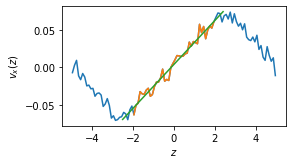

In [85]:
L = 10
w = 1

linear_part = velocity_profile[np.abs(velocity_profile[:,0])<L/4. - w/2.]
plt.figure(figsize=(4,2.2))
plt.plot(velocity_profile[:,0], velocity_profile[:,1])
plt.plot(linear_part[:,0], linear_part[:,1])

gamma_dot,b = np.polyfit(linear_part[:,0], linear_part[:,1], 1)
a = np.arange(-L/4.,L/4.,0.1)
plt.plot(a, gamma_dot*a+b)
plt.xlabel('$z$')
plt.ylabel('$v_x(z)$')
plt.show()

You can fit both linear parts, or fit a full triangle to increase accuracy, or numerically determine the derivative, as shown below. It is important to exclude the exchange regions regardless of method used, because the velocity profile is usually not linear inside the exchange regions. 

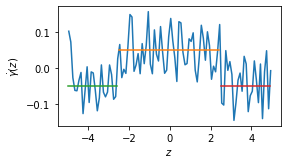

In [80]:
plt.figure(figsize=(4,2.2))
dx = velocity_profile[1,0]-velocity_profile[0,0]
grad = np.gradient(velocity_profile[:,1],dx)
plt.plot(velocity_profile[:,0], grad)
b = np.arange(-L/2.,-L/4.,0.1)
c = np.arange(L/4.,L/2.,0.1)
plt.plot(a, gamma_dot*np.ones(len(a)))
plt.plot(b, -gamma_dot*np.ones(len(b)))
plt.plot(c, -gamma_dot*np.ones(len(c)))

plt.xlabel('$z$')
plt.ylabel('$\dot \gamma(z)$')
plt.show()

We exchanged a momentum of roughly 1 every 10 timesteps, so 1 per $0.05$ time, since the timestep during the simulation was `dt=0.005`. We can check by calculating the average, which should be close to 1. Then, we simply have to divide $\tau$ by $\dot \gamma$:

In [91]:
# skipping first entry, because that one will be zero in any case
mom_av = np.average(data[1:,1])
tau = mom_av/(2*L*L*0.05)
viscosity = tau/gamma_dot
print(viscosity)

3.3771214459639465


The original publication reports viscosity values around 3.2-3.3, so this very simple and short simulation gives a rough good first estimate already. For increasing the accuracy of this estimate, you should determine the viscosity at different shear rates and plot your results $\tau$ vs $\dot \gamma$.   

We have observed unexpected secondary flows in elongated boxes (see this [publication](https://arxiv.org/pdf/1811.04097.pdf) for details), so it is worthwhile to carefully check for box size effects.
You should test the smalles and biggest dimensions you are intending to use in your simulations. 

Also vary the parameters of the reverse perturbation to check for systematic effects. Sweep a reasonable set of shear rates to determine the upper and lower limit of the acsessible linear response regime. 

Look for unwanted gradients in temperature, density or velocity along all spatial dimensions. 


### Future reading:

- Original publication: Florian Mueller-Plathe. Reversing the perturbation innonequilibrium
    molecular dynamics:  An easy way to calculate the shear viscosity of
    fluids. Phys. Rev. E, 59:4894-4898, May 1999.
    <http://dx.doi.org/10.1103/PhysRevE.59.4894>
- Follow-up publications, describe the algorithm in more detail: 
    * Müller-Plathe, F., & Bordat, P. (2004). Reverse Non-equilibrium Molecular Dynamics. Lecture Notes in Physics, 310–326. <http://dx.doi.org/10.1007/978-3-540-39895-0_10>
    * Müller-Plathe, F., & Reith, D. (1999). Cause and effect reversed in non-equilibrium molecular dynamics: an easy route to transport coefficients. Computational and Theoretical Polymer Science, 9(3-4), 203–209. <http://dx.doi.org/10.1016/s1089-3156(99)00006-9>
- Our own publications about the method, describe some of the observed problems of the algorithm: 
    * Instability of Shear Flows in Spatially Periodic Domains, MP Howard, A Statt, HA Stone, TM Truskett, arXiv preprint arXiv:1907.07086 <https://arxiv.org/pdf/1907.07086.pdf>
    * Unexpected secondary flows in reverse nonequilibrium shear flow simulations, A Statt, MP Howard, AZ Panagiotopoulos, Physical Review Fluids 4 (4), 043905 <https://arxiv.org/pdf/1811.04097.pdf>
- This is the documentation page of the lammps implementation of the same algorithm: https://lammps.sandia.gov/doc/fix_viscosity.html Comparing against a different simulation package can be a useful exercise for finding bugs.


